Este notebook tiene como objetivo enseñar una manera de clasificar imágenes para identificar una clase usando **fastbook**, una librería de **fastai**.

In [3]:
# Importamos las librerías que vamos a usar para nuestra clasificación de imágenes. Nos pedirá acceder a nuestro dive,
# ya que va a almacenar las imágenes en la carpeta de archivos que aparece a la izquierda en Google Colab.

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 38.5 MB/s 
     |████████████████████████████████| 189 kB 52.8 MB/s 
     |████████████████████████████████| 48 kB 5.4 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 51 kB 336 kB/s 
     |████████████████████████████████| 558 kB 44.8 MB/s 
     |████████████████████████████████| 130 kB 49.5 MB/s 
Mounted at /content/gdrive


Cargamos el dataset, en este caso el notebook clasificará imágenes de 'Boxer', 'Labrador' y 'Doberman'. Puedes poner las imágenes que tú quieras.

In [4]:
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
#Si hay que reejecutarlo quita el comentario del else para que continúe cuando se quiera, ya que algunas imágenes dan fallo en la descarga.

tipos_perros = 'Doberman', 'Labrador', 'Boxer'
path = Path('perros')

if not path.exists():
  path.mkdir()
#else:
  for o in tipos_perros:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'raza de perro {o}')
    cont = 0
    for i in results:
      if cont == 60: break
      download_url(i, str(dest) + "/" + str(cont) + ".jpg")
      cont+= 1

In [9]:
path = Path('perros')

fns = get_image_files(path)
fns

failed = verify_images(fns)
failed

failed.map(Path.unlink);

In [12]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [13]:
perros = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

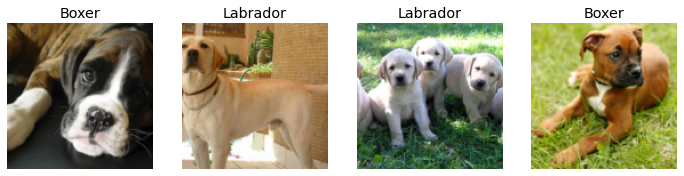

In [14]:
dls = perros.dataloaders(path)

dls.valid.show_batch(max_n=4, nrows=1)

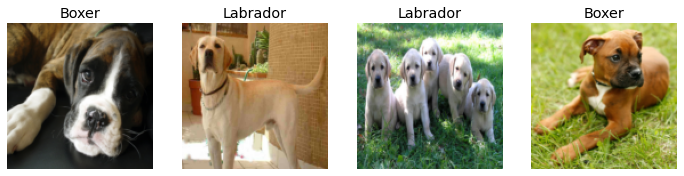

In [15]:
perros = perros.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = perros.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

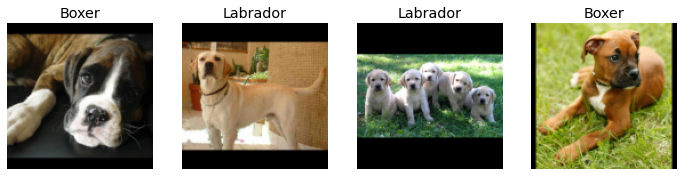

In [16]:
perros = perros.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = perros.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

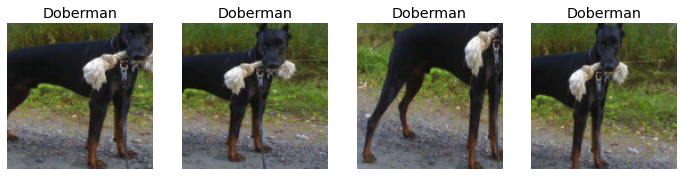

In [17]:
perros = perros.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = perros.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


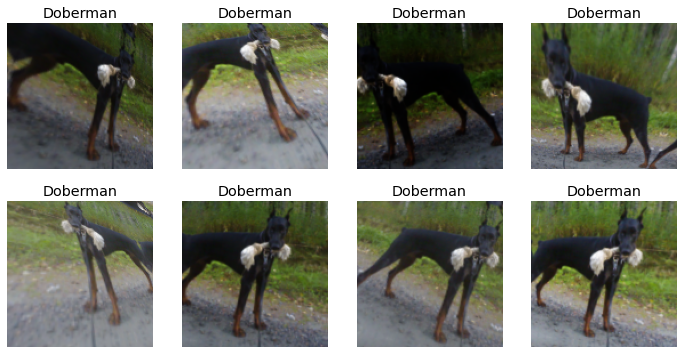

In [18]:
perros = perros.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = perros.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [19]:
perros = perros.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = perros.dataloaders(path)

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.843267,2.238177,0.535714,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.471821,1.626495,0.464286,00:04
1,1.505249,0.839983,0.357143,00:04
2,1.317670,0.409538,0.285714,00:04
3,1.056180,0.233197,0.071429,00:04


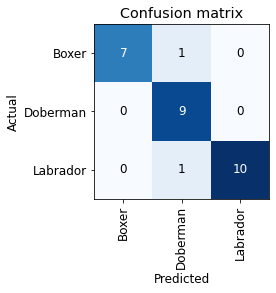

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

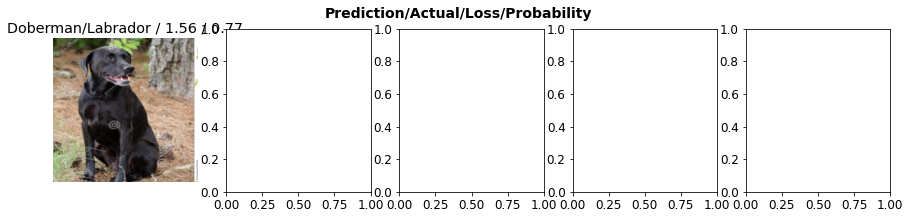

In [22]:
interp.plot_top_losses(5, nrows=1)

In [23]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

###Convertimos el modelo en una aplicación

In [24]:
learn.export()

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
#learn_inf.predict('images/tuimagen.jpg')

In [27]:
learn_inf.dls.vocab

['Boxer', 'Doberman', 'Labrador']

##Haz click en el botón upload y selecciona tu imagen para predecir:

In [38]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [39]:
img = PILImage.create(btn_upload.data[-1])

In [40]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [44]:
pred,pred_idx,probs = learn_inf.predict(img)

Veamos el resultado de la predicción:

In [48]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Labrador; Probability: 0.9764')

Para la calsificación mejor usemos un botón:

In [50]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [51]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

#Uniendo todo podemos ponerlo así:

In [52]:
VBox([widgets.Label('Sube una imagen de tu perro:'), 
      btn_upload, btn_run, out_pl, lbl_pred])